# 16. Regression - inference

In [170]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display
import matplotlib.pyplot as plt

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

# Set style for seaborn plots
sns.set_style('dark')
sns.color_palette("viridis", as_cmap=True)

# Import libraries for regression
import statsmodels.formula.api as smf

In [171]:
baby = pd.read_csv('baby.csv')
baby = baby.rename(columns={
    'Birth Weight': 'birth_weight',
    'Gestational Days': 'gestational_days',
    'Maternal Age': 'maternal_age',
    'Maternal Height': 'maternal_height',
    'Maternal Pregnancy Weight': 'maternal_pregnancy_weight',
    'Maternal Smoker': 'maternal_smoker'
})
baby.head()

,birth_weight,gestational_days,maternal_age,maternal_height,maternal_pregnancy_weight,maternal_smoker
0,120,284,27,62,100,False
1,113,282,33,64,135,False
2,128,279,28,64,115,True
3,108,282,23,67,125,True
4,136,286,25,62,93,False


## 1. Setting up the regression model

<Axes: xlabel='gestational_days', ylabel='birth_weight'>

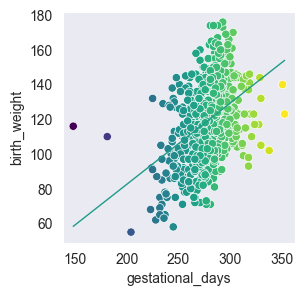

In [117]:
plt.figure(figsize=(3, 3))
sns.scatterplot(data = baby,
                x = 'gestational_days',
                y = 'birth_weight',
                hue = 'gestational_days',
                palette = 'viridis',
                legend = False)
sns.regplot(data = baby,
                x = 'gestational_days',
                y = 'birth_weight',
                scatter = False,
                order = 1,
                ci = None,
                line_kws = {'color': '#209B87', 'linewidth': 1})

In [101]:
weight_gest = smf.ols('birth_weight ~ gestational_days', data=baby).fit()
weight_gest.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           birth_weight   R-squared:                       0.166
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     233.4
Date:                Sat, 06 Jan 2024   Prob (F-statistic):           3.40e-48
Time:                        01:20:56   Log-Likelihood:                -4973.3
No. Observations:                1174   AIC:                             9951.
Df Residuals:                    1172   BIC:                             9961.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept          -10.7541      8.537     -1.260      0.208     -27.504       5.995
gestational_days     0.4666      0.031     15.278      0.000       0.407       0.526
==============================================================================
Omnibus:                        3.976   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.137   Jarque-Bera (JB):                3.892
Skew:                           0.114   Prob(JB):                        0.143
Kurtosis:                       3.166   Cond. No.                     4.88e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.88e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [102]:
slope = weight_gest.params['gestational_days']
slope

0.46655687694921555

But had the scatter plot come out differently, the regression line would have been different and might have had a different slope. How do we figure out how different the slope might have been?

We need another sample of points, so that we can draw the regression line through the new scatter plot and find its slope. But from where will get another sample?

You have guessed it – we will bootstrap our original sample. That will give us a bootstrapped scatter plot, through which we can draw a regression line.

## 2. Bootstrapping

We can bootstrap the scatter plot a large number of times, and draw a regression line through each bootstrapped plot. Each of those lines has a slope. We can simply collect all the slopes and draw their empirical histogram. Recall that by default, the sample method draws at random with replacement, the same number of times as the number of rows in the table. That is, sample generates a bootstrap sample by default.

,Simulation,Slope
0,1,0.519225
1,2,0.392125
2,3,0.417347
3,4,0.558331
4,5,0.437093


<Axes: xlabel='Slope', ylabel='Count'>

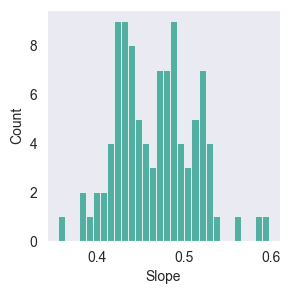

In [116]:
def slope_simulation(dataset, y, x):
    data = []
    for i in range(1, rep+1):
        # shuffling
        bootstrap_sample = dataset.sample(frac = 1, replace = True).reset_index(drop=True)
        # regress
        bootstrap_reg = smf.ols(f'{y} ~ {x}', data=bootstrap_sample).fit()
        # extract slope
        bootstrap_slope = bootstrap_reg.params[x]
        # append
        data.append({
            'Simulation': i,
            'Slope': bootstrap_slope
        })
    datadf = pd.DataFrame(data)
    return datadf

rep = int(input("Enter the number of simulations:"))

results = slope_simulation(baby, 'birth_weight', 'gestational_days')
display(results.head())

plt.figure(figsize=(3, 3))
sns.histplot(data = results,
             x = 'Slope',
             color = '#209B87',
             bins = 30)

In [104]:
# Finding the CI: 95%
left_bound = np.percentile(results['Slope'], 2.5)
right_bound = np.percentile(results['Slope'], 97.5)
print(left_bound, ",", right_bound)

0.3823440661879921 , 0.5639912834395626


It does include the 0.46655687694921555 slope.

An approximate 95% confidence interval for the true slope extends from about 0.38 ounces per day to about 0.56 ounces per day.

0.2037041771896813

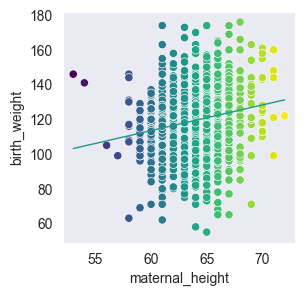

In [115]:
plt.figure(figsize=(3, 3))
sns.scatterplot(data = baby,
                x = 'maternal_height',
                y = 'birth_weight',
                hue = 'maternal_height',
                palette = 'viridis',
                legend = False)
sns.regplot(data = baby,
                x = 'maternal_height',
                y = 'birth_weight',
                ci = None,
                scatter = False,
                line_kws = {'color': '#209B87', 'linewidth': 1})
baby[['maternal_height', 'birth_weight']].corr().loc['maternal_height', 'birth_weight']

## 3. Another variable: x = age, y = weight

Null Hypothesis. The slope of the true line is 0.

Alternative Hypothesis. The slope of the true line is not 0.

,Simulation,Slope
0,1,0.200772
1,2,0.270100
2,3,0.081715
3,4,0.086162
4,5,-0.014784


<Axes: xlabel='Slope', ylabel='Count'>

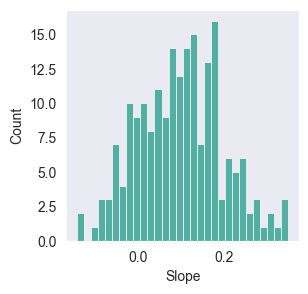

In [114]:
rep = int(input("Enter the number of simulations:"))

results2 = slope_simulation(baby, 'birth_weight', 'maternal_age')
display(results2.head())

plt.figure(figsize=(3, 3))
sns.histplot(data = results2,
             x = 'Slope',
             color = '#209B87',
             bins = 30)

In [124]:
weight_age = smf.ols('birth_weight ~ maternal_age', data=baby).fit()
slope = weight_age.params['maternal_age']

In [144]:
maternal_age_300 = pd.DataFrame({'maternal_age': [300]})
fitted_value = weight_age.predict(new_data)
fitted_value.loc[0]


142.65020954659894

In [108]:
# Finding the CI: 95%
left_bound2 = np.percentile(results2['Slope'], 2.5)
right_bound2 = np.percentile(results2['Slope'], 97.5)
print(left_bound2, ",", right_bound2)

-0.11953834562916824 , 0.25920741615989745


Based on the ACTUAL sample, the slope of the regression line for estimating birth weight based on maternal age is positive, about 0.08 ounces per year. It does lie in the 95% conf interval -> fail to reject null.

## 4. Prediction

The goal here is to make predictions for a new individual's birth weight based on the number of gestational days, using the regression model. (aka. simply find the fitted value given x).

Again we wanna run a bootstrap simulation then compare it to the observed y.

In [148]:
baby

,birth_weight,gestational_days,maternal_age,maternal_height,maternal_pregnancy_weight,maternal_smoker
0,120,284,27,62,100,False
1,113,282,33,64,135,False
2,128,279,28,64,115,True
3,108,282,23,67,125,True
4,136,286,25,62,93,False
...,...,...,...,...,...,...
1169,113,275,27,60,100,False
1170,128,265,24,67,120,False
1171,130,291,30,65,150,True
1172,125,281,21,65,110,False


,Simulation,Fitted value for given x
0,1,128.741583
1,2,127.286451
2,3,130.711998
3,4,128.838051
4,5,129.124695


Confidence interval: (126.57631318142099, 131.19441629727058)


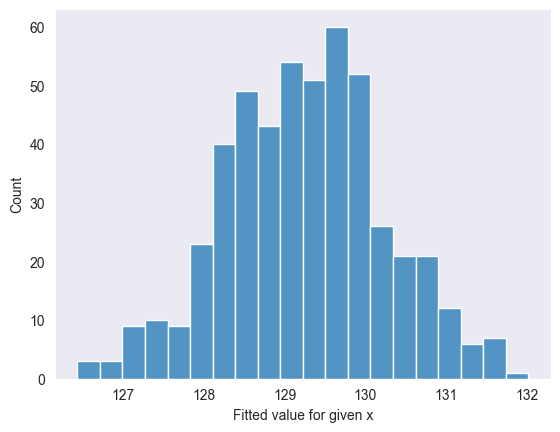

In [168]:
def fitted_value():
    rep = int(input("Enter the number of simulations:"))
    dataset = input("Enter the name of the data set:") 
    y = str(input("Enter the name of the explained variable:"))
    x = str(input("Enter the name of the predictor variable:"))
    given_x = int(input("Enter the x value you wanna find the fitted value for:"))
    dataset = globals()[dataset]
    data = []
    for i in range(1, rep+1):
        bootstrap_sample_fit = dataset.sample(frac = 1, replace = True).reset_index(drop = True)
        bootstrap_reg_fit = smf.ols(f'{y} ~ {x}', data=bootstrap_sample_fit).fit()
        new_data_with_x = pd.DataFrame({f'{x}': [given_x]})
        bootstrap_fitted_value = bootstrap_reg_fit.predict(new_data_with_x).loc[0]
        data.append({
            'Simulation': i,
            'Fitted value for given x': bootstrap_fitted_value
        })
    datadf = pd.DataFrame(data)

    # CI
    left_fit = np.percentile(datadf['Fitted value for given x'], 0.25)
    right_fit = np.percentile(datadf['Fitted value for given x'], 97.5)

    # display results
    display(datadf.head())
    sns.histplot(data = datadf, x = 'Fitted value for given x', bins = 20)
    print(f"Confidence interval: ({left_fit}, {right_fit})")
    
    return datadf

datadf = fitted_value()

In [169]:
datadf['Fitted value for given x'].dropna().mean()

129.2559983259724